In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, time, holidays
import xgboost as xgb
from darts import TimeSeries
from darts.metrics import mape, rmse
from darts.models import XGBModel
from statsmodels.graphics.tsaplots import plot_pacf
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 22})

In [45]:
def read_load_data():
    base_dir = os.getcwd()
    load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
    load_data = pd.read_csv(load_file_path)
    load_data.rename(columns={
        "Actual Total Load [MW] - BZN|SE4": "Actual Load",
        "Time (UTC)": "Time"
    }, inplace=True)
    load_data['Time'] = pd.to_datetime(load_data['Time'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
    load_data.set_index('Time', inplace=True)
    load_data.drop('Day-ahead Total Load Forecast [MW] - BZN|SE4', axis=1, inplace=True)
    return load_data

data = read_load_data()

In [46]:
def import_weather_data(df):
    base_dir = os.getcwd()
    temperature_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
    humidity_file_path = os.path.join(base_dir, 'weighted_avg_humidity.csv')
    solar_file_path = os.path.join(base_dir, 'weighted_avg_solar.csv')
    avg_temperature_data = pd.read_csv(temperature_file_path)
    avg_humidity_data = pd.read_csv(humidity_file_path)
    avg_solar_data = pd.read_csv(solar_file_path)
    df['Temperature'] = avg_temperature_data['weighted_avg'].values
    df['Humidity'] = avg_humidity_data['weighted_avg'].values
    df['Solar'] = avg_solar_data['weighted_avg'].values
    return df

data = import_weather_data(data)

In [47]:
def import_swedish_holidays(df):
    years = np.arange(2015, 2025)
    raw_holidays = []
    for date, name in sorted(holidays.Sweden(years=years).items()):
        if not name == "Söndag":
            raw_holidays.append(date)
        raw_holidays.append(date)
    holiday_dates = set(raw_holidays)
    df['is_holiday'] = pd.Series(df.index.date).isin(holiday_dates).astype(int).values
    return df

data = import_swedish_holidays(data)

In [48]:
def create_date_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    return df

data = create_date_features(data)

In [ ]:
#_ = plot_pacf(data["Actual Load"], lags=168) # checked autocorrelation of load for one week (hourly)

In [17]:
def create_lag_features(df, column="Actual Load"):
    for lag in range(1, 25):  # Hourly lags
        df[f'lag_{lag}'] = df[column].shift(lag)

    for day in range(2, 8):  # Start from 2*24 = 48 to avoid lag_24 duplication
        lag = day * 24
        df[f'lag_{lag}'] = df[column].shift(lag)
    return df

data = create_lag_features(data)
data = data.dropna() # first week in 2015 dropped to enable lag features

In [49]:
print(data.head())

                     Actual Load  Temperature   Humidity  Solar  is_holiday  \
Time                                                                          
2015-01-01 00:00:00       2267.0     4.451320  86.611602    0.0           1   
2015-01-01 01:00:00       2281.0     4.217264  85.613668    0.0           1   
2015-01-01 02:00:00       2313.0     4.302403  85.022984    0.0           1   
2015-01-01 03:00:00       2372.0     4.207889  86.857752    0.0           1   
2015-01-01 04:00:00       2424.0     4.572334  85.142699    0.0           1   

                     hour  dayofweek  is_weekend  
Time                                              
2015-01-01 00:00:00     0          3           0  
2015-01-01 01:00:00     1          3           0  
2015-01-01 02:00:00     2          3           0  
2015-01-01 03:00:00     3          3           0  
2015-01-01 04:00:00     4          3           0  


In [ ]:
def add_noise_to_covariates(df, noise_level: float = 0.05):
    stochastic_cols = ["Temperature", "Humidity", "Solar"]
    df_noisy = df.copy()

    for col in stochastic_cols:
        if col in df_noisy.columns:
            if col == "Solar":
                # Proportional noise based on value (avoid large noise when value is 0)
                base = df_noisy[col].values
                noise = np.random.normal(0, noise_level * base)
                df_noisy[col] += noise
                df_noisy[col] = df_noisy[col].clip(lower=0)  # Prevent negative solar
            else:
                # Standard deviation-based noise
                std = df_noisy[col].std()
                noise = np.random.normal(0, noise_level * std, size=len(df_noisy))
                df_noisy[col] += noise

    return df_noisy


future_data = add_noise_to_covariates(data)

In [52]:
# Time-based train/test split
split_dates = ['2022-01-01','2023-01-01','2024-01-01']
train = pd.concat([
    data[split_dates[0]:split_dates[2]],              
    #data[split_dates[2]:split_dates[3]]
])
#valid = pd.concat([
#    data[split_dates[1]:split_dates[2]],
    #data[split_dates[3]:split_dates[4]] 
#])
test = pd.concat([
    future_data[split_dates[2]:],# add noise
    #data[split_dates[4]:]              
])
test_unaltered = pd.concat([
    data[split_dates[2]:],# add noise
    #data[split_dates[4]:]              
])

In [53]:
features = [col for col in data.columns if col not in ['Actual Load']]
X_train, y_train = train[features], train['Actual Load']
#X_valid, y_valid = valid[features], valid['target']
X_test, y_test = test[features], test['Actual Load']

In [54]:
# Hyperparameter space
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300, 350],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
}

# Model and search setup
base_model = xgb.XGBModel(
    objective="reg:squarederror",
    tree_method="hist",         
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    verbosity=0
)

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,  
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1
)

# Using grid search
#search = GridSearchCV(
#    estimator=base_model,
#    param_grid=param_dist,  
#    scoring='neg_root_mean_squared_error',
#    cv=3,
#    verbose=2,
#    n_jobs=1
#)
# Run search
start = time.time()
search.fit(X_train, y_train)
print("Search took", round((time.time() - start)/60, 2), "minutes")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END co

In [55]:
# Evaluate best model
best_model = search.best_estimator_
print("Best params:", search.best_params_)

# on test set
y_pred_test = best_model.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
print("Test RMSE:", rmse_test)

mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

Best params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Test RMSE: 221.26435280186953
MAPE: 6.93%


NameError: name 'mdates' is not defined

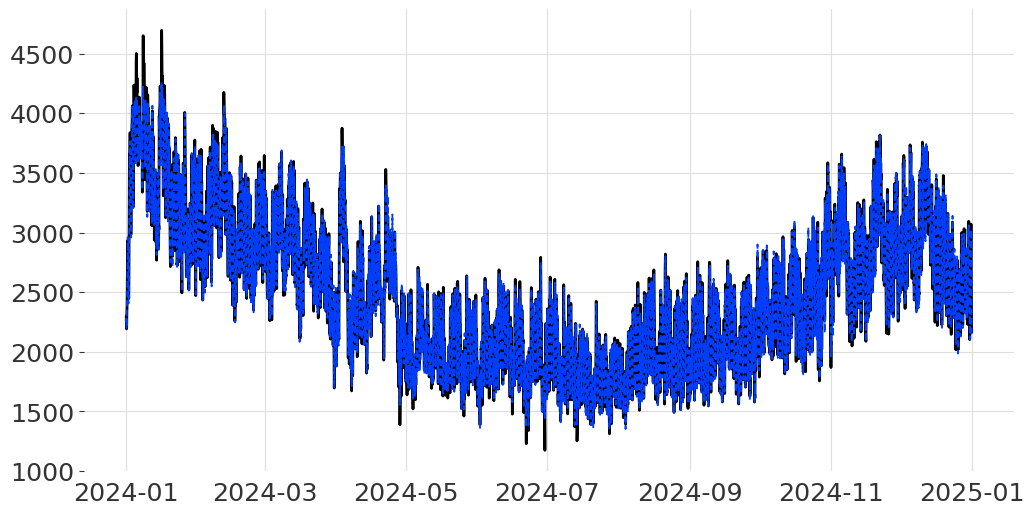

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred_test, label='Predicted', linestyle='--')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.legend()
plt.title('Load Forecast: Actual vs Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance Plot
xgb.plot_importance(best_model, height=0.6, max_num_features=15)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()